In [4]:
import pandas as pd
import numpy as np

df = pd.read_csv("Data_Washington Fatal Crash Survey.csv", low_memory=False)
zips = pd.read_csv("US%20Zip%20Codes%20from%202013%20Government%20Data.txt")

In [9]:
from arcgis.geocoding import reverse_geocode
from arcgis.geometry import Geometry
from arcgis.gis import GIS



#'methdrug', 'drugsts', drugtst1-12, drugres1-12, 'alcres', 'alcsts', 'alctst'
#ejectpath alcmeth
#investjur repjur

We will drop all columns that are more than 90% NANs because there are not enough values for them to be significant. We'll also drop columns that are not relevant to the problem statement: ['hosp_tm','arr_tm','not_tm','investjur','repjur','lab','methdrug','alcmeth','drugsts','drugtst1']

## Derive zip code for crashes 

Method: Reverse geocoding with ArcGIS and impute any missing zipcode values

In [10]:
# long : x
# lat : y

# driver zip code : dzip 
df.rename(columns={'x': 'lon', 'y': 'lat'}, inplace=True)

In [12]:
gis = GIS(api_key="AAPK206d8c337d5a416ca8a7824330c0ca7bkQWmIxSD8K5_qxX1ly5btaWLcl36cVX_1iDwCQxl_IgY56Zh6TN-Usx26i4oM77l")
# exposed for now

def get_zip(df,lon_field, lat_field):
    location = reverse_geocode((Geometry({"x":float(df[lon_field]),"y":float(df[lat_field]), "spatialReference":{"wkid":4326}})))
    return location['address']['Postal']

df['crashzip'] = df.apply(get_zip, axis=1, lat_field='lat', lon_field='lon')

In [83]:
# update missing crash zip values in df 
# case 78 03/18/2020 in county 45(Pacific) --> crash lat long improperly recorded  78.304936,  -778.304936 impossible! city = unincorporated
# FOREST SERVICES RD 2300 is not an actual road... should we drop the row?
# case 349 09/12/2021 in county 5 --> zip: 99352 could not be identified by arcGIS identified using haversine distance
# case 638 09/05/2021 in county 19(Ferry) --> lat long recorded as 78.304936,  -778.304936 impossible! city = unincorporated
# Ferry county is on a reservation in the middle of nowhere next to a natl forest far northeast of WA 
# crash occurred on BRIDGE CREEK RD in Ferry County --> brute force zip: 99138

df.loc[3690,"crashzip"] = 99352
df.loc[4128,"crashzip"] = 99138

In [84]:
# saved because computationally expensive 
# don't want to call API every time we run the code 
# DONT RUN THAT PART 

df.to_csv('crashdata_updated.csv') # import THIS data set

## What proportion of drivers involved in fatal crashes crash in communities where they live?

Method: Calculate proportion mathematically

In [384]:
# start from here

data = pd.read_csv("crashdata_updated.csv", low_memory=False) # some cols have mixed dtypes...
data["crash_dt"]= pd.to_datetime(data["crash_dt"])
data["licstate"]= data["licstate"].astype(str)

# Among drivers involved in fatal crashes, what proportion are involved in crashes in communities where they live?

# How do we want to define "community"? Zip code should be fine... 
data['dzip'] = data['dzip'].astype(str)
# get rid of the trailing zeros
data['dzip'] = data['dzip'].replace(r'\.0$', '', regex=True)

In [595]:
data

,index,Unnamed: 0,year,case,par,repjur,crash_dt,crash_tm,accday,accmon,...,crf3,CoRoadName,CoMP,IntCoRoadName,IntCoMP,crashzip,d_res,dcity,crashcity,d_cty
0,0,0,2017,1,E628946,2.0,2017-01-01,2:12,1,1,...,NaN,NaN,NaN,NaN,NaN,98201,visitor,Everett,Everett,resident
1,1,1,2017,2,E627989,26.0,2017-01-02,17:14,2,1,...,NaN,NaN,NaN,NaN,NaN,98359,visitor,Tacoma,Olalla,visitor
2,2,2,2017,4,3747633,263.0,2017-01-01,18:47,1,1,...,NaN,NaN,NaN,NaN,NaN,98103,visitor,Seattle,Seattle,resident
3,3,3,2017,5,E628691,4.0,2017-01-01,3:50,1,1,...,NaN,NaN,NaN,NaN,NaN,99224,visitor,Mead,Spokane,visitor
4,4,4,2017,6,3746306,263.0,2017-01-05,9:53,5,1,...,NaN,NaN,NaN,NaN,NaN,98104,visitor,Snoqualmie,Seattle,visitor
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4026,4127,4127,2021,636,Incid08,334.0,2021-08-08,9:38,8,8,...,NaN,NaN,NaN,NaN,NaN,99116,visitor,Nespelem,Coulee dam,visitor
4027,4128,4128,2021,638,Incid09,334.0,2021-09-05,1:36,5,9,...,NaN,NaN,NaN,NaN,NaN,99138,resident,Inchelium,Inchelium,resident
4028,4129,4129,2021,639,EB48605,263.0,2021-04-21,17:32,21,4,...,NaN,NaN,NaN,NaN,NaN,98144,visitor,Lacey,Seattle,visitor
4029,4130,4130,2021,639,EB48605,263.0,2021-04-21,17:32,21,4,...,NaN,NaN,NaN,NaN,NaN,98144,resident,Seattle,Seattle,resident


In [385]:
# In order for this calculation to be accurate, we need to remove the rows where BOTH zip code and state is "unknown" or "not reported" because the driver zip for each of these rows won't match the crash zip but we have no way validating where the driver is ACTUALLY from-- we cannot assume that the driver is from out of state/country 

# Answers hinge on the assumption that the driver's zip code for each observation is accurate 
for index, row in data.iterrows():
    if row['dzip']=='99999' and row['licstate']=='99':
        data.drop(index, inplace=True)
    if row['dzip']=='99999' and row['licstate']=='98':
        data.drop(index, inplace=True)
    if row['dzip']=='99998' and row['licstate']=='99':
        data.drop(index, inplace=True)
    if row['dzip']=='99998' and row['licstate']=='98':
        data.drop(index, inplace=True)
    if row['dzip']=='99998' and row['licstate']=='53':
        data.drop(index, inplace=True)

In [386]:
# should be done

data.reset_index(inplace=True)

In [387]:
# For the crashes where driver's zip is "unknown" (99999) but state is known --> ok to keep since they are out of state
print(data[['licstate','dzip']].iloc[1359], "State/Country=Alabama") # index 1359 licstate = 1 (ALABAMA) 
print(data[['licstate','dzip']].iloc[984], "State/Country = Canada") # index 984 licstate = 95 (CANADA) No ZIP 

licstate        1
dzip        99999
Name: 1359, dtype: object State/Country=Alabama
licstate       95
dzip        99999
Name: 984, dtype: object State/Country = Canada


In [538]:
print("The proportion of drivers involved in fatal crashes where they don't live = {}".format(len(data.query('dzip != crashzip'))/len(data)))
print("The proportion of drivers involved in fatal crashes where they live = {}".format(len(data.query('dzip == crashzip'))/len(data)))

The proportion of drivers involved in fatal crashes where they don't live = 0.7568841478541305
The proportion of drivers involved in fatal crashes where they live = 0.2431158521458695


- Calculate the same proportions for before Spring 2020 and after Spring 2020
- Represent these 3 proportions in a horizontal stacked bar chart 

## Recalculate proportions-- this time community = CITY

In [532]:
# Source: https://github.com/scpike/us-state-county-zip
citydata = pd.read_csv("geo-data.csv")

In [534]:
# match city to zip codes

def matchcity(df, dct):
    dct = dict(zip(citydata['zipcode'], citydata['city']))
    df['dcity']=df['dzip'].map(dct).fillna('00') # map over df 
    df['crashcity']=df['crashzip'].map(dct).fillna('00') # map over df 
    return df

In [535]:
citydict = dict(zip(citydata['zipcode'], citydata['city']))

# call our function 
matchcity(data, citydict)

,index,Unnamed: 0,year,case,par,repjur,crash_dt,crash_tm,accday,accmon,...,crf2,crf3,CoRoadName,CoMP,IntCoRoadName,IntCoMP,crashzip,d_res,dcity,crashcity
0,0,0,2017,1,E628946,2.0,2017-01-01,2:12,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,98201,visitor,Everett,Everett
1,1,1,2017,2,E627989,26.0,2017-01-02,17:14,2,1,...,NaN,NaN,NaN,NaN,NaN,NaN,98359,visitor,Tacoma,Olalla
2,2,2,2017,4,3747633,263.0,2017-01-01,18:47,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,98103,visitor,Seattle,Seattle
3,3,3,2017,5,E628691,4.0,2017-01-01,3:50,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,99224,visitor,Mead,Spokane
4,4,4,2017,6,3746306,263.0,2017-01-05,9:53,5,1,...,NaN,NaN,NaN,NaN,NaN,NaN,98104,visitor,Snoqualmie,Seattle
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4026,4127,4127,2021,636,Incid08,334.0,2021-08-08,9:38,8,8,...,NaN,NaN,NaN,NaN,NaN,NaN,99116,visitor,Nespelem,Coulee dam
4027,4128,4128,2021,638,Incid09,334.0,2021-09-05,1:36,5,9,...,NaN,NaN,NaN,NaN,NaN,NaN,99138,resident,Inchelium,Inchelium
4028,4129,4129,2021,639,EB48605,263.0,2021-04-21,17:32,21,4,...,NaN,NaN,NaN,NaN,NaN,NaN,98144,visitor,Lacey,Seattle
4029,4130,4130,2021,639,EB48605,263.0,2021-04-21,17:32,21,4,...,NaN,NaN,NaN,NaN,NaN,NaN,98144,resident,Seattle,Seattle


In [537]:
print("The proportion of drivers involved in fatal crashes in communities where they don't live = {}".format(len(data.query('dcity != crashcity'))/len(data)))
print("The proportion of drivers involved in fatal crashes in communities where they live = {}".format(len(data.query('dcity == crashcity'))/len(data)))

The proportion of drivers involved in fatal crashes in communities where they don't live = 0.6889109402133465
The proportion of drivers involved in fatal crashes in communities where they live = 0.3110890597866534


- Calculate the same proportions for before Spring 2020 and after Spring 2020
- Represent these 3 proportions in a horizontal stacked bar chart 

## Is there a difference between types of crashes and behavior factors among residents vs visitors?

Method: Chi-Squared Test for Homogeneity between crashes among residents and visitors

- null hypothesis: Visitor and Resident populations are homogeneous regarding the proportions of categories of categorical variables (crash/behavior factors)

In [391]:
# Create a categorical variable to represent whether driver is local resident or visitor
# "resident" = local resident
# "visitor" = out of town

drive_res = [] # set empty list 
for index, row in data.iterrows():
    if row['dzip']==row['crashzip']:
        drive_res.append("resident") # if equal add "resident" to list
    else:
        drive_res.append("visitor") # else add "visitor"
        
data["d_res"] = drive_res # cast list as df column

In [542]:
# Create a categorical variable to represent whether driver is local resident or visitor
# "resident" = local resident
# "visitor" = out of town

### BASED ON CITY MATCH

city_res = [] # set empty list 
for index, row in data.iterrows():
    if row['dcity']==row['crashcity']:
        city_res.append("resident") # if equal add "resident" to list
    else:
        city_res.append("visitor") # else add "visitor"
        
data["d_cty"] = city_res # cast list as df column

# "d_cty" : classifies driver as resident or visitor by CITY 
# "d_res" : classifies driver as resident or visitor by ZIP

In [203]:
# method: chi-squared test of homogeneity 

# Is there a difference between the types of crashes among residents vs visitors?
# Is there a difference between the behavior factors among residents vs visitors?

In [392]:
# experimental crosstabs to look at the data lol

# crash level
crash_tab = pd.crosstab([data.numfatal,data.roadclass,data.pv_inv,data.ped_inv,data.ht_inv,data.bike_inv,data.mc_inv],data.d_res, rownames = ["Fatalities", "RoadClass","PV_inv","PED_inv","HT_inv","Bike_inv", "MC_inv"],colnames = ["Driver"],margins=True, margins_name="Total")

crashtype = pd.crosstab([data.numfatal,data.crashtype],data.d_res, rownames = ["Fatalities", "Crashtype"],colnames = ["Driver"],margins=True, margins_name="Total")

# driver behavior level
behav_tab = pd.crosstab([data.dd_inv,data.speed_inv,data.drowsy_inv,data.drdist_inv],data.d_res, rownames = ["Drinking","Speeding","Drowsy","Distract"],colnames = ["Driver"],margins=True, margins_name="Total")

In [393]:
crashtype

Driver                resident  visitor  Total
Fatalities Crashtype                          
1          0                 4       15     19
           1                89      233    322
           2                34       91    125
           3                 1        1      2
           5                 1        1      2
...                        ...      ...    ...
4          50                0        1      1
           51                1        0      1
           86                0        1      1
           87                0        1      1
Total                      980     3051   4031

[115 rows x 3 columns]

In [394]:
behav_tab

Driver                             resident  visitor  Total
Drinking Speeding Drowsy Distract                          
0        0        0      0              355     1120   1475
                         1              149      406    555
                  1      0               15       35     50
                         1                0        3      3
         1        0      0              124      490    614
                         1               15       64     79
                  1      0                2        4      6
1        0        0      0              126      452    578
                         1               46      101    147
                  1      0                2        6      8
         1        0      0              137      328    465
                         1                9       42     51
Total                                   980     3051   4031

## Are there specific resident ZIP Codes that tend to produce higher-risk drivers that are involved in fatal crashes at a higher rate?

- We define the rate at which zip codes tend to produce higher risk drivers as the sum of drivers from each zip code divided by the 5 year span to get the average number of high risk drivers produced by a zip code per year

In [380]:
# note: we know there are 28 fatal crashes caused by drivers from CANADA

In [708]:
# rate of drivers causing fatal crashes per zipcode per year
riskrate = pd.DataFrame(data['dzip'].value_counts()/5).head(17) # 17 instead of 15 because 15,16,17 are equal

In [688]:
risky = pd.DataFrame(data.groupby(data.crash_dt.dt.year)['dzip'].value_counts())
risky.rename(columns={'dzip':'counts'},inplace=True)

In [689]:
top17 = list(riskrate.index)
risky.reset_index(inplace=True)
# get data with just top 15 highest risk zip codes

highrisk = risky[risky['dzip'].isin(top17)]
print("The top 17 zip codes that produce high risk drivers are: {}".format(top17))
# 0 is canada

The top 17 zip codes that produce high risk drivers are: ['99301', '98444', '98387', '98837', '98404', '98391', '98951', '98003', '98901', '98223', '98258', '99206', '98584', '98022', '0', '98902', '98168']


In [709]:
riskrate.reset_index(inplace=True)

In [691]:
risky['Risk']=risky['dzip'].isin(top17).astype(int)

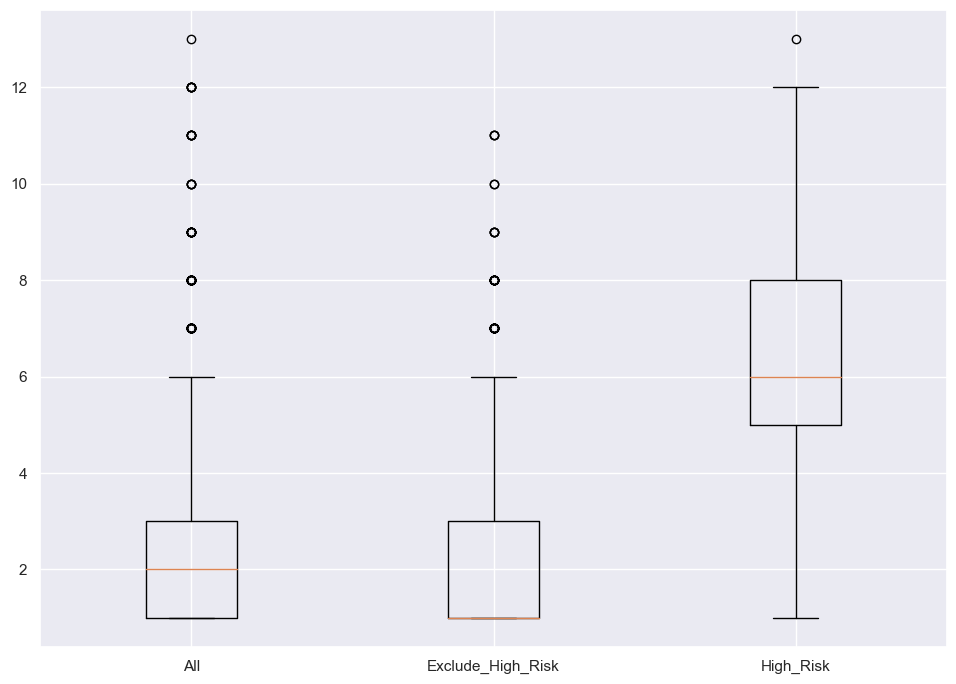

In [755]:
plt.boxplot([risky['counts'], risky[risky['Risk'] == 0]['counts'] , risky[risky['Risk'] == 1]['counts']], labels=['All','Exclude_High_Risk','High_Risk'])
plt.show(box)

In [710]:
# change name of 'index' to avoid errors 

riskrate.rename(columns={'index':'zipcode', 'dzip':'rate'}, inplace=True)

In [711]:
citydct = dict(zip(citydata['zipcode'], citydata['city']))
ctydct = dict(zip(citydata['zipcode'], citydata['county']))
state = dict(zip(citydata['zipcode'], citydata['state']))

# match 'city', 'county', 'state' to High Risk Zip Codes
riskrate['city']=riskrate['zipcode'].map(citydct).fillna('00') 
riskrate['county']=riskrate['zipcode'].map(ctydct).fillna('00') 
riskrate['state']=riskrate['zipcode'].map(state).fillna('00') 

In [721]:
# fill in missing except Canada
# Bonney Lake, WA Pierce 
riskrate.at[5,'city']='Bonney Lake'
riskrate.at[5,'county']='Pierce'
riskrate.at[5,'state']='Washington'

## What are the population demographics of these high-risk driver producing ZIP Codes?

The top 17 highest risk zip codes belong to 8 counties in WA state, excluding Canada. 

To analyze the demographics of high-risk producing zip codes, we examine the demographics of the county to which it belongs. We also examine how many people in each of the counties belong to high-risk zip codes. 

In [747]:
# add population size 
washpop = pd.read_csv("washpop.csv",  converters = {'Zip Code': str})

washpop.rename(columns={'Zip Code':'zipcode','Population':'population'}, inplace=True)
washpop['population'] = washpop['population'].replace(',', '', regex=True).astype(int)

In [753]:
# match ZCTA population data to zip code

population = dict(zip(washpop['zipcode'], washpop['population']))
riskrate['population']=riskrate['zipcode'].map(population).fillna('00') # map over df 

In [756]:
riskrate['county'].unique()

array(['Franklin', 'Pierce', 'Grant', 'Yakima', 'King', 'Snohomish',
       'Spokane', 'Mason', '00'], dtype=object)

In [758]:
riskrate['population'] = riskrate['population'].replace(',', '', regex=True).astype(int)

In [760]:
# read in population demographic data from the census
# read in median income data 

income = pd.read_csv("med_income_washco.csv")
demo = pd.read_csv("highriskdemographics.csv")